# Lecture 2 Finance Practice
## Data finance (Peru / US)
- **BCRPData API (Peru)** (official): https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api
- **Yahoo Finance** via `yfinance` (US market data): https://ranaroussi.github.io/yfinance/
- **INEI open data (Peru)** (ENAPREF sample CSV): https://www.datosabiertos.gob.pe/


In [85]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 120)

In [86]:
START = "2022-01-01"
END = "2025-12-18"

In [87]:
# --- BCRP: daily PEN/USD buy & sell (official API) ---
# Codes:
# - PD04637PD: USD/PEN (buy)
# - PD04638PD: USD/PEN (sell)

import requests

bcrp_url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04638PD/json/{START}/{END}/esp"
try:
    r = requests.get(bcrp_url, timeout=30)
    r.raise_for_status()
    bcrp_obj = r.json()
except Exception as e:
    bcrp_obj = {"periods": []}
    print("BCRP request failed:", type(e).__name__, str(e))

periods = bcrp_obj.get("periods", [])
rows = []
for p in periods:
    name = p.get("name")
    vals = p.get("values", [])
    if isinstance(vals, str):
        vals = [vals]
    if name is None or not isinstance(vals, list) or len(vals) < 2:
        continue
    rows.append([name, vals[0], vals[1]])

fx = pd.DataFrame(rows, columns=["date_raw", "PENUSD_buy", "PENUSD_sell"])

# Convert numeric
if fx.shape[0] > 0:
    fx["PENUSD_buy"] = pd.to_numeric(fx["PENUSD_buy"].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan}), errors="coerce")
    fx["PENUSD_sell"] = pd.to_numeric(fx["PENUSD_sell"].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan}), errors="coerce")

# Parse dates (BCRP labels can be ISO-like or ddMonYY or Mon.YYYY)
if fx.shape[0] > 0:
    s = fx["date_raw"].astype(str).str.strip()

    # ISO parse
    dt_iso = pd.to_datetime(s, errors="coerce")

    # Monthly like Mar.2020
    mask_monthly = s.str.match(r"^[A-Za-zÁÉÍÓÚÑñ]{3}\.[0-9]{4}$", na=False)
    mon_map = {
        "Ene":"Jan","Feb":"Feb","Mar":"Mar","Abr":"Apr","May":"May","Jun":"Jun",
        "Jul":"Jul","Ago":"Aug","Set":"Sep","Sep":"Sep","Oct":"Oct","Nov":"Nov","Dic":"Dec"
    }
    mon_es = s.where(mask_monthly).str.slice(0,3)
    year4 = s.where(mask_monthly).str.slice(4,8)
    mon_en = mon_es.map(mon_map)
    dt_monthly = pd.to_datetime(mon_en + "." + year4, format="%b.%Y", errors="coerce")

    # Daily like 18Dic25
    mask_daily = s.str.match(r"^[0-9]{2}[A-Za-zÁÉÍÓÚÑñ]{3}[0-9]{2}$", na=False)
    day = s.where(mask_daily).str.slice(0,2)
    mon_es2 = s.where(mask_daily).str.slice(2,5)
    yy = pd.to_numeric(s.where(mask_daily).str.slice(5,7), errors="coerce")
    mon_en2 = mon_es2.map(mon_map)
    year = np.where(yy <= 69, 2000 + yy, 1900 + yy)
    year_s = pd.Series(year).astype("Int64").astype(str)
    dt_daily = pd.to_datetime(day + mon_en2 + year_s, format="%d%b%Y", errors="coerce")

    dt = dt_iso.copy()
    dt = dt.fillna(dt_monthly)
    dt = dt.fillna(dt_daily)

    fx["date"] = dt
    fx = fx.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

fx.head(), fx.tail(), fx.shape

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17484\1773827851.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_iso = pd.to_datetime(s, errors="coerce")


(    date_raw  PENUSD_buy  PENUSD_sell       date
 0  01.Feb.22    3.871333     3.877667 2022-02-01
 1  02.Feb.22    3.852000     3.857000 2022-02-02
 2  03.Feb.22    3.858500     3.860833 2022-02-03
 3  04.Feb.22    3.863000     3.867833 2022-02-04
 4  07.Feb.22    3.838500     3.845833 2022-02-07,
       date_raw  PENUSD_buy  PENUSD_sell       date
 579  24.Nov.25    3.382857     3.385286 2025-11-24
 580  25.Nov.25    3.375143     3.377214 2025-11-25
 581  26.Nov.25    3.365000     3.366857 2025-11-26
 582  27.Nov.25    3.364143     3.366429 2025-11-27
 583  28.Nov.25    3.360714     3.362500 2025-11-28,
 (584, 4))

In [88]:
# --- Yahoo Finance via yfinance: US tickers (real market data) ---
tickers = ["SPY", "QQQ", "TLT", "GLD", "EEM"]

try:
    import yfinance as yf
except Exception as e:
    yf = None
    print("Could not import yfinance:", type(e).__name__, str(e))

if yf is not None:
    try:
        data = yf.download(tickers, start=START, end=END, auto_adjust=True, progress=False)
    except Exception as e:
        data = pd.DataFrame()
        print("yfinance download failed:", type(e).__name__, str(e))
else:
    data = pd.DataFrame()

# Convert to long format: date, ticker, close, volume
if isinstance(data, pd.DataFrame) and data.shape[0] > 0:
    if isinstance(data.columns, pd.MultiIndex):
        close = data["Close"].copy()
        vol = data["Volume"].copy()
    else:
        close = data[["Close"]].rename(columns={"Close": tickers[0]})
        vol = data[["Volume"]].rename(columns={"Volume": tickers[0]})

    close.index.name = "date"
    vol.index.name = "date"

    us_close_long = close.reset_index().melt(id_vars="date", var_name="ticker", value_name="close")
    us_vol_long = vol.reset_index().melt(id_vars="date", var_name="ticker", value_name="volume")
    us_mkt = us_close_long.merge(us_vol_long, on=["date","ticker"], how="inner").dropna(subset=["close"])
else:
    us_mkt = pd.DataFrame(columns=["date","ticker","close","volume"])

us_mkt.head(), us_mkt.shape

(        date ticker      close    volume
 0 2022-01-03    EEM  44.624969  27572700
 1 2022-01-04    EEM  44.470764  24579500
 2 2022-01-05    EEM  43.745163  46425100
 3 2022-01-06    EEM  43.944714  34288700
 4 2022-01-07    EEM  44.343792  32640900,
 (4970, 4))

In [89]:
# INEI: read correctly using '|' as delimiter (pipe-separated file)
inei_url = "https://www.datosabiertos.gob.pe/sites/default/files/Cap.%20100_Vivienda-Hogar_Muestra.csv"

inei = pd.read_csv(
    inei_url,
    sep="|",            # <-- key fix: the file is pipe-separated
    nrows=3000,
    low_memory=False,
    encoding_errors="replace"
)

inei.shape, list(inei.columns)[:5], inei.head()


((200, 286),
 ['ANIO', 'MES', 'CONGLOME', 'VIVIENDA', 'HOGAR'],
    ANIO  MES  CONGLOME  VIVIENDA  HOGAR  UBIGEO  DOMINIO  ESTRATO  PERIODO  \
 0  2008    6         1        15     11   10101        4        4        3   
 1  2008    6         1        46     11   10101        4        4        3   
 2  2008    6         1        62     11   10101        4        4        3   
 3  2008    6         1        88     11   10101        4        4        3   
 4  2008    6         1        99     11   10101        4        4        3   
 
    TIPO  RFINAL  REEMPLAZO  P101  P102  P102_A  P103  P104_1  P104_A1  \
 0     1       4          0   NaN   NaN     NaN   NaN     NaN      NaN   
 1     1       1          0   1.0   2.0     NaN  40.0     2.0      NaN   
 2     1       1          0   1.0   2.0     NaN  50.0     2.0      NaN   
 3     1       1          0   1.0   2.0     NaN  30.0     2.0      NaN   
 4     1       1          0   1.0   2.0     NaN  20.0     2.0      NaN   
 
    P104_B1  P

## 3.2 Pandas Series

### 3.2.1 From lists to Series exercise

Using `fx`:

1. Create `PENUSD_mid = (PENUSD_buy + PENUSD_sell) / 2`.
2. Take the **last 15 mid values** as a Python list.
3. Create a `pd.Series` from that list.
4. Name it `PENUSD_mid_last15`.

In [90]:
fx["PENUSD_mid"] = (fx["PENUSD_buy"] + fx["PENUSD_sell"]) / 2

PENUSD_mid_last15 = pd.Series(
    fx["PENUSD_mid"].dropna().tail(15).tolist(),
    name="PENUSD_mid_last15"
)

PENUSD_mid_last15

0     3.370750
1     3.359500
2     3.368214
3     3.364071
4     3.370393
5     3.362321
6     3.367964
7     3.376429
8     3.379857
9     3.388214
10    3.384071
11    3.376179
12    3.365929
13    3.365286
14    3.361607
Name: PENUSD_mid_last15, dtype: float64

### 3.2.2 From NumPy array to Series 

Using `us_mkt`:

1. Filter to `ticker == "SPY"`.
2. Take `close` as a NumPy array.
3. Create a Series indexed by `date` named `SPY_close_series`.
4. Compute the mean/min/max with Series methods.

In [91]:

# 1 Filter rows where ticker == "SPY" and keep only the columns we need.
spy_df = us_mkt.loc[us_mkt["ticker"].eq("SPY"), ["date", "close"]].dropna(subset=["date", "close"])

# 2 Convert the 'close' column to a NumPy array (this is what the exercise asks for)
spy_close_np = spy_df["close"].to_numpy()

# 3 Convert the 'date' column to datetime and use it as the Series index.
#    Name the Series exactly as required: "SPY_close_series".
SPY_close_series = pd.Series(
    spy_close_np,
    index=pd.to_datetime(spy_df["date"]),
    name="SPY_close_series"
)

# 4 Compute summary statistics using pandas Series methods.
summary_stats = {
    "mean": SPY_close_series.mean(),
    "min": SPY_close_series.min(),
    "max": SPY_close_series.max(),
}

SPY_close_series.head(), summary_stats

(date
 2022-01-03    451.875183
 2022-01-04    451.723785
 2022-01-05    443.049744
 2022-01-06    442.633545
 2022-01-07    440.883545
 Name: SPY_close_series, dtype: float64,
 {'mean': np.float64(485.6085832008653),
  'min': 341.1820983886719,
  'max': 687.1395263671875})

### 3.2.3 From Dictionary to Series 

Using `us_mkt`:

1. Compute the **last available close** for each ticker in `tickers`.
2. Store it in a dict `{ticker: last_close}`.
3. Convert to a Series and sort descending.

In [92]:
# Ensure we have only the relevant columns, remove missing closes, and sort by date
tmp = us_mkt.loc[:, ["date", "ticker", "close"]].dropna(subset=["date", "close"]).copy()
tmp["date"] = pd.to_datetime(tmp["date"])
tmp = tmp.sort_values(["ticker", "date"])

# Step 1 + 2: build dict {ticker: last_close}
last_close_by_ticker = (
    tmp.groupby("ticker")["close"]
       .last()                 # last row per ticker after sorting by date
       .to_dict()              # convert to dict
)

# Step 3: convert dict -> Series and sort descending
last_close_series = (
    pd.Series(last_close_by_ticker, dtype=float)
      .sort_values(ascending=False)
)

last_close_series

SPY    669.421936
QQQ    600.409973
GLD    399.290009
TLT     87.459633
EEM     52.599998
dtype: float64

### 3.2.4 Series vs NumPy 

Goal: show why pandas alignment matters.

1. Create two Series indexed by date:
   - FX mid-rate from `fx`
   - SPY close from `us_mkt`
2. Combine them into a DataFrame (pandas aligns on dates).
3. Separately, build two NumPy arrays by truncating to the same length.
4. In markdown: explain why alignment is safer.

In [93]:
# --- FX mid-rate Series (indexed by date) ---
fx_mid = (
    fx.loc[:, ["date", "PENUSD_buy", "PENUSD_sell"]]
      .dropna(subset=["date", "PENUSD_buy", "PENUSD_sell"])
      .assign(PENUSD_mid=lambda d: (d["PENUSD_buy"] + d["PENUSD_sell"]) / 2)
      .set_index("date")["PENUSD_mid"]
      .sort_index()
)

# --- SPY close Series (indexed by date) ---
spy_close = (
    us_mkt.loc[us_mkt["ticker"].eq("SPY"), ["date", "close"]]
         .dropna(subset=["date", "close"])
)

spy_close["date"] = pd.to_datetime(spy_close["date"])
spy_close_series = spy_close.set_index("date")["close"].sort_index()

# --- pandas alignment: align on the date index automatically ---
aligned_df = pd.DataFrame({"FX_mid": fx_mid, "SPY_close": spy_close_series}).dropna()

# --- NumPy approach: truncate arrays to the same length (no date alignment) ---
# NOTE: This can compare different dates if the series have missing days or different calendars.
n = min(len(fx_mid), len(spy_close_series))
fx_np = fx_mid.to_numpy()[:n]
spy_np = spy_close_series.to_numpy()[:n]

aligned_df.head(), fx_np.shape, spy_np.shape

(              FX_mid   SPY_close
 date                            
 2022-02-01  3.874500  428.454163
 2022-02-02  3.854500  432.616180
 2022-02-03  3.859667  422.447632
 2022-02-04  3.865417  424.434082
 2022-02-07  3.842167  423.071960,
 (584,),
 (584,))

### 3.2.5 Indexing 

1. From `last_close_series`, use `.iloc` to select the top 3 tickers.
2. Use `.loc` to select the SPY value.

In [94]:
# 1) Top 3 by position (first three entries)
top3 = last_close_series.iloc[:3]

# 2) SPY value by label (safe lookup: returns NaN if SPY is missing)
spy_value = last_close_series.get("SPY", np.nan)

top3, spy_value

(SPY    669.421936
 QQQ    600.409973
 GLD    399.290009
 dtype: float64,
 np.float64(669.4219360351562))

## 3.3 DataFrame

### 3.3.1 DataFrame Generation 

1. Build a DataFrame with daily FX mid-rate and SPY close aligned by date.
2. Create columns:
   - `FX_ret` and `SPY_ret` using `pct_change()`
   - `FX_abs_change` = absolute day-to-day change in FX mid
3. Keep columns in this order:
   `["PENUSD_mid","SPY_close","FX_ret","SPY_ret","FX_abs_change"]`

In [95]:
# --- Step 1: Create the FX mid-rate series indexed by date ---
# We compute the mid-rate as the average of buy and sell, then keep it as a clean, date-indexed Series.
fx_mid = (
    fx.loc[:, ["date", "PENUSD_buy", "PENUSD_sell"]]
      .dropna(subset=["date", "PENUSD_buy", "PENUSD_sell"])                 # remove rows with missing pieces
      .assign(PENUSD_mid=lambda d: (d["PENUSD_buy"] + d["PENUSD_sell"]) / 2) # mid = (buy + sell)/2
      .set_index("date")["PENUSD_mid"]                                      # turn into a Series indexed by date
      .sort_index()                                                         # sort so time-based operations make sense
)

# --- Step 2: Create the SPY close series indexed by date ---
# We filter us_mkt to SPY only, then build a clean Series with date as the index.
spy_close_series = (
    us_mkt.loc[us_mkt["ticker"].eq("SPY"), ["date", "close"]]   # keep only SPY rows and the needed columns
         .dropna(subset=["date", "close"])                      # drop missing dates/closes
)
spy_close_series["date"] = pd.to_datetime(spy_close_series["date"])          # ensure dates are true datetimes
spy_close_series = (
    spy_close_series.set_index("date")["close"]                # make it a Series indexed by date
                  .sort_index()                                # sort by date
)

# --- Step 3: Align FX and SPY by date in a single DataFrame ---
# Pandas aligns automatically by the index (date). dropna() keeps only dates present in BOTH series.
df = pd.DataFrame({
    "PENUSD_mid": fx_mid,
    "SPY_close": spy_close_series
}).dropna()

# --- Step 4: Create return and change features ---
# pct_change() computes (today / yesterday - 1), i.e., simple daily returns.
df_features = df.copy()
df_features["FX_ret"] = df_features["PENUSD_mid"].pct_change()               # daily FX return
df_features["SPY_ret"] = df_features["SPY_close"].pct_change()               # daily SPY return

# Absolute day-to-day change in FX mid-rate (in PEN per USD).
df_features["FX_abs_change"] = df_features["PENUSD_mid"].diff().abs()        # |mid_t - mid_{t-1}|

# --- Step 5: Keep columns in the required order ---
df_features = df_features[["PENUSD_mid", "SPY_close", "FX_ret", "SPY_ret", "FX_abs_change"]]

df_features.head()

,PENUSD_mid,SPY_close,FX_ret,SPY_ret,FX_abs_change
date,,,,,
2022-02-01,3.874500,428.454163,NaN,NaN,NaN
2022-02-02,3.854500,432.616180,-0.005162,0.009714,0.020000
2022-02-03,3.859667,422.447632,0.001340,-0.023505,0.005167
2022-02-04,3.865417,424.434082,0.001490,0.004702,0.005750
2022-02-07,3.842167,423.071960,-0.006015,-0.003209,0.023250


### 3.3.2 Indexing 

1. Use `.iloc` to select first 10 rows of returns only.
2. Use `.loc` to select a date range in 2024.

In [96]:
# 1) First 10 rows of returns only (position-based)
first10_rets = df_features.loc[:, ["FX_ret", "SPY_ret"]].iloc[:10]

# 2) Date range selection in 2024 (label-based, using the datetime index)
range_2024 = df_features.loc["2024-01-01":"2024-12-31"]

first10_rets, range_2024.head()

(              FX_ret   SPY_ret
 date                          
 2022-02-01       NaN       NaN
 2022-02-02 -0.005162  0.009714
 2022-02-03  0.001340 -0.023505
 2022-02-04  0.001490  0.004702
 2022-02-07 -0.006015 -0.003209
 2022-02-08 -0.000564  0.008228
 2022-02-09 -0.004970  0.014636
 2022-02-10 -0.017252 -0.017965
 2022-02-11 -0.000222 -0.019719
 2022-02-14  0.008835 -0.003269,
             PENUSD_mid   SPY_close    FX_ret   SPY_ret  FX_abs_change
 date                                                                 
 2024-02-01    3.805250  477.398163  0.018104  0.076213       0.067667
 2024-02-02    3.832000  482.423981  0.007030  0.010528       0.026750
 2024-02-05    3.855667  480.667389  0.006176 -0.003641       0.023667
 2024-02-06    3.856250  482.062866  0.000151  0.002903       0.000583
 2024-02-07    3.864667  486.083527  0.002183  0.008341       0.008417)

### 3.3.3 General Methods 
1. Use `.describe()` for return columns.
2. Find the 5 highest SPY daily returns and the dates.
3. Create `FX_direction` = "up" if `FX_ret > 0` else "down".
4. Count how many "up" days per calendar year.

In [97]:
# Make sure FX_direction exists (from the previous step)
df_features["FX_direction"] = np.where(df_features["FX_ret"] > 0, "up", "down")

# Extract years only for "up" days (this returns an array of years, one per "up" day)
up_years = df_features.index[df_features["FX_direction"].eq("up")].year

# Count occurrences of each year (no groupby used)
up_days_per_year = pd.Series(up_years).value_counts().sort_index()

up_days_per_year

date
2022    66
2023    71
2024    72
2025    57
Name: count, dtype: int64

### 3.3.4 Importing Data 

Using INEI sample `inei`:

1. Display shape and first 5 columns.
2. Pick 2 columns and rename to snake_case.
3. Keep only those 2 columns in a new DataFrame `inei_small`.

In [98]:
# 3.3.4 Importing Data (solution after reading with sep="|")
#
# 1) Show shape and first 5 columns
inei_shape = inei.shape
inei_first5_cols = list(inei.columns)[:5]

# 2) Pick two columns and rename to snake_case
inei_small = (
    inei.loc[:, ["ANIO", "MES"]]
        .rename(columns={"ANIO": "year", "MES": "month"})
)

inei_shape, inei_first5_cols, inei_small.head()


((200, 286),
 ['ANIO', 'MES', 'CONGLOME', 'VIVIENDA', 'HOGAR'],
    year  month
 0  2008      6
 1  2008      6
 2  2008      6
 3  2008      6
 4  2008      6)

### 3.3.5 Filtering Data 

Using `df_features`:

1. Filter days where `SPY_ret < -0.02` (large negative days).
2. Filter days where `FX_abs_change` is in the top 1%.
3. Compare counts.

In [99]:
# 1) Days where SPY had a large negative return (< -2%)
neg_spy_days = df_features.loc[df_features["SPY_ret"] < -0.02]

# 2) Days where FX_abs_change is in the top 1% (>= 99th percentile)
fx_threshold = df_features["FX_abs_change"].quantile(0.99)
fx_jump_days = df_features.loc[df_features["FX_abs_change"] >= fx_threshold]

len(neg_spy_days), len(fx_jump_days)

(24, 6)

### 3.3.6 Dealing with Nulls 
Using `us_mkt`:

1. Copy `us_mkt` to `us_mkt_nan`.
2. Set 1% of `close` to NaN (fixed random seed).
3. Create:
   - `us_drop`: drop NaNs
   - `us_fill`: fill NaNs with ticker-specific median close
4. Compare shapes.

In [100]:
# 1 Copy
us_mkt_nan = us_mkt.copy()

# 2 Set ~1% of close to NaN 
idx = us_mkt_nan.sample(frac=0.01, random_state=42).index
us_mkt_nan.loc[idx, "close"] = np.nan

# 3 Drop NaNs
us_drop = us_mkt_nan.dropna(subset=["close"]).copy()

# Fill NaNs with ticker-specific median (NO groupby)
tickers_unique = us_mkt_nan["ticker"].dropna().unique()

median_by_ticker = {
    t: us_mkt_nan.loc[us_mkt_nan["ticker"].eq(t), "close"].median()
    for t in tickers_unique
}

us_fill = us_mkt_nan.copy()
us_fill["close"] = us_fill["close"].fillna(us_fill["ticker"].map(median_by_ticker))

# 4 Compare shapes
us_mkt.shape, us_mkt_nan.shape, us_drop.shape, us_fill.shape

((4970, 4), (4970, 4), (4920, 4), (4970, 4))

### 3.3.7 Duplicates 

1. Create `dup_df` by stacking the last 5 rows of `us_mkt` twice.
2. Detect duplicates using `.duplicated()`.
3. Remove them using `.drop_duplicates()`.

In [101]:
# 1Stack the last 5 rows twice
last5 = us_mkt.tail(5)
dup_df = pd.concat([last5, last5], axis=0, ignore_index=True)

# 2 Detect duplicates (True means "this row is a duplicate of a previous row")
dup_mask = dup_df.duplicated()

# 3 Remove duplicates (keep the first occurrence by default)
dedup_df = dup_df.drop_duplicates().reset_index(drop=True)

dup_df.shape, dedup_df.shape


((10, 4), (5, 4))

### 3.3.8 Groupby 


Using `us_mkt`:

1. Group by `ticker` and compute:
   - mean close
   - median close
   - max volume
2. Rename columns clearly.
3. Sort by mean close descending.

In [102]:
ticker_summary = (
    us_mkt
    .dropna(subset=["ticker", "close"])              # ensure close exists for the stats
    .groupby("ticker")
    .agg(
        mean_close=("close", "mean"),                # average close per ticker
        median_close=("close", "median"),            # median close per ticker
        max_volume=("volume", "max")                 # max volume per ticker (NaN-safe)
    )
    .sort_values("mean_close", ascending=False)      # highest mean close first
)

ticker_summary

,mean_close,median_close,max_volume
ticker,,,
SPY,485.608583,460.739990,256611400
QQQ,411.806857,400.730164,198685800
GLD,220.130422,187.864998,62025000
TLT,91.395622,88.549709,131353500
EEM,40.462350,39.107407,134225700


### 3.3.9 Reshape 

1. Create a 1-row wide DataFrame with last closes per ticker.
2. Convert it to long format with `melt()` into columns: `ticker`, `last_close`.
3. Pivot `us_mkt` into a wide table: index=`date`, columns=`ticker`, values=`close` (keep first 50 dates).

In [103]:
# 1  1-row wide DataFrame with last closes per ticker ---
# We sort by ticker and date so "last" means the most recent observation for each ticker.
tmp = us_mkt.loc[:, ["date", "ticker", "close"]].dropna(subset=["date", "ticker", "close"]).copy()
tmp["date"] = pd.to_datetime(tmp["date"])
tmp = tmp.sort_values(["ticker", "date"])

# Get last close per ticker (Series indexed by ticker), then convert to a 1-row DataFrame
last_close_series = tmp.groupby("ticker")["close"].last()
wide_last = last_close_series.to_frame().T
wide_last.index = ["last_close"]  # optional: label the single row

# 2 Convert wide -> long using melt() ---
# Reset index so melt has a normal DataFrame to work with.
long_last = (
    wide_last.reset_index(drop=True)
            .melt(var_name="ticker", value_name="last_close")
)

# 3 Pivot long us_mkt into a wide close table (date x ticker) ---
# Pivot creates a table where each ticker is a column and each row is a date.
wide_close = (
    tmp.pivot(index="date", columns="ticker", values="close")
       .sort_index()
       .head(50)
)

wide_last, long_last.head(), wide_close.head()

(ticker            EEM         GLD         QQQ         SPY        TLT
 last_close  52.599998  399.290009  600.409973  669.421936  87.459633,
   ticker  last_close
 0    EEM   52.599998
 1    GLD  399.290009
 2    QQQ  600.409973
 3    SPY  669.421936
 4    TLT   87.459633,
 ticker            EEM         GLD         QQQ         SPY         TLT
 date                                                                 
 2022-01-03  44.624969  168.330002  392.184082  451.875183  125.295334
 2022-01-04  44.470764  169.570007  387.097321  451.723785  124.774353
 2022-01-05  43.745163  169.059998  375.205231  443.049744  124.097099
 2022-01-06  43.944714  166.990005  374.941620  442.633545  124.418365
 2022-01-07  44.343792  167.750000  370.879974  440.883545  123.524025)

### 3.3.10 Merge (Assignment)

Goal: merge Peru macro data (BCRP) with US market data (Yahoo) at monthly frequency.

1. Fetch BCRP monthly policy rate: code `PD12301MD`.
2. Build a monthly SPY average close from `us_mkt`.
3. Merge the two tables.
4. Save to `outputs/lecture2_policy_spy_monthly.csv`.

In [104]:
# Fetch BCRP monthly policy rate (official API)
policy_url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD12301MD/json/{START}/{END}/esp"
try:
    r = requests.get(policy_url, timeout=30)
    r.raise_for_status()
    pol_obj = r.json()
except Exception as e:
    pol_obj = {"periods": []}
    print("BCRP policy request failed:", type(e).__name__, str(e))

rows = []
for p in pol_obj.get("periods", []):
    name = p.get("name")
    vals = p.get("values", [])
    if isinstance(vals, str):
        vals = [vals]
    if name is None or not isinstance(vals, list) or len(vals) < 1:
        continue
    rows.append([name, vals[0]])

policy = pd.DataFrame(rows, columns=["date_raw", "policy_rate"])
if policy.shape[0] > 0:
    policy["policy_rate"] = pd.to_numeric(policy["policy_rate"].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan}), errors="coerce")

    s = policy["date_raw"].astype(str).str.strip()
    dt_iso = pd.to_datetime(s, errors="coerce")

    mask_monthly = s.str.match(r"^[A-Za-zÁÉÍÓÚÑñ]{3}\.[0-9]{4}$", na=False)
    mon_map = {
        "Ene":"Jan","Feb":"Feb","Mar":"Mar","Abr":"Apr","May":"May","Jun":"Jun",
        "Jul":"Jul","Ago":"Aug","Set":"Sep","Sep":"Sep","Oct":"Oct","Nov":"Nov","Dic":"Dec"
    }
    mon_es = s.where(mask_monthly).str.slice(0,3)
    year4 = s.where(mask_monthly).str.slice(4,8)
    mon_en = mon_es.map(mon_map)
    dt_monthly = pd.to_datetime(mon_en + "." + year4, format="%b.%Y", errors="coerce")

    policy["date"] = dt_iso.fillna(dt_monthly)
    policy = policy.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

policy.head(), policy.tail()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17484\4062083830.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_iso = pd.to_datetime(s, errors="coerce")


(    date_raw  policy_rate       date
 0  01.Feb.22          3.0 2022-02-01
 1  02.Feb.22          3.0 2022-02-02
 2  03.Feb.22          3.0 2022-02-03
 3  04.Feb.22          3.0 2022-02-04
 4  07.Feb.22          3.0 2022-02-07,
       date_raw  policy_rate       date
 589  24.Nov.25         4.25 2025-11-24
 590  25.Nov.25         4.25 2025-11-25
 591  26.Nov.25         4.25 2025-11-26
 592  27.Nov.25         4.25 2025-11-27
 593  28.Nov.25         4.25 2025-11-28)

In [105]:
from pathlib import Path
Path("outputs").mkdir(exist_ok=True)

spy_monthly = (
    us_mkt.loc[us_mkt["ticker"].eq("SPY"), ["date", "close"]]
         .dropna(subset=["date", "close"])
         .assign(date=lambda d: pd.to_datetime(d["date"]))
         .set_index("date")["close"]
         .resample("M")
         .mean()
         .rename("spy_close_avg")
         .reset_index()
)

policy_monthly = (
    policy.loc[:, ["date", "policy_rate"]]
          .dropna(subset=["date", "policy_rate"])
          .assign(date=lambda d: pd.to_datetime(d["date"]))
          .sort_values("date")
)

merged_monthly = policy_monthly.merge(spy_monthly, on="date", how="inner")

out_path = Path("outputs/lecture_2_finance.csv")
merged_monthly.to_csv(out_path, index=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17484\2495546726.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


# Exercise 1:

### The file ```AMZN_options_2025-12-22.csv``` contains options data for amazon. For those of you not familiar with option data, an option is a financial derivatives that pays at expiration time $T$ and strike $K>0$:

$$C(K,T)=(S_T-K)_+ \text{  if a call option}$$
$$P(K,T)=(K-S_T)_+ \text{  if a put option}$$

It is well known, that Put-Call parity implies the following relation:

$$C(K,T)-P(K,T)=S(T)-K\cdot DF(T)$$
where $S(T)$ is the underlying price and $DF(T)$ is the discount factor.
### a) Compute a new column labelled ```mid_price``` which corresponds to:
$$\text{mid price}=\frac{\text{bid}+\text{ask}}{2}$$
### b) For each available ```expiration_date``` perform a linear regression using the ```mid_price``` only for options ```whose trade_volume>25``` (note that both calls and puts need to satisfy this condition):
$$C(K,T)-P(K,T)=a+b K$$ where $a$ corresponds to $S(T)$ and $b$ corresponds to $DF(T)$.

### you can use ```numpy.polyfit(x, y, deg=1)``` to fit a linear regression and obtain the coefficients
### c) Plot $S(T)$ and  $DF(T)$ as a function of $T$

### Note: you will need to transform dates into time, $T$ in years to to us eyou will need to use the ```datetime``` library. Here goes an example

**Note (2025 data):** In this solution we use the snapshot file `AMZN_options_2025-12-22.csv` (trade_date = 2025-12-22).


In [ ]:
import pandas as pd                      
import datetime                          

# 2025 snapshot from Yahoo (trade_date = 2025-12-22)
option_chain = pd.read_csv('AMZN_options_2025-12-22.csv')  

# Parse dates
option_chain['expiration_date'] = pd.to_datetime(option_chain['expiration_date'])  
# Convert the 'expiration_date' column from text to real datetime objects,
# so we can subtract dates and do time-to-maturity calculations.

# Use trade_date in the file as valuation date (16:00 close), fallback to hard-coded date
if 'trade_date' in option_chain.columns:  
    # Check if the dataset contains a 'trade_date' column (the snapshot date).
    
    option_chain['trade_date'] = pd.to_datetime(option_chain['trade_date'])  
    # Convert 'trade_date' to datetime as well (same reason: proper date operations).
    
    val_date = option_chain['trade_date'].max()  
    # Take the maximum trade_date in the file. Usually the whole file is one snapshot day,
    # so max() just gives that snapshot date.
    
    current_date = datetime.datetime(val_date.year, val_date.month, val_date.day, 16, 0, 0)  
    # Build a valuation timestamp at 16:00 (market close) on that snapshot day.
    # We use 16:00 because options quotes are often interpreted as end-of-day-ish.
else:
    # If 'trade_date' is not available, we manually set the valuation datetime.
    
    current_date = datetime.datetime(2025, 12, 22, 16, 0, 0)  
    # Hard-code the valuation timestamp to 2025-12-22 at 16:00.

# Normalize option_type to C/P (the original notebook expects 'C' and 'P')
option_chain['option_type'] = (
    option_chain['option_type']                         # Start from the existing option_type column...
    .astype(str)                                        # ...make sure everything is a string...
    .str.lower()                                        # ...lowercase it for consistent matching...
    .map({'call':'C','put':'P','c':'C','p':'P'})         # ...translate call/put labels into 'C'/'P'...
    .fillna(option_chain['option_type'])                 # ...and keep the original value if it wasn’t recognized.
)
# After this, the column should use 'C' for calls and 'P' for puts,
# which matches the notation used in the original exercise.

time_to_maturity_timestamp = option_chain['expiration_date'] - current_date  
# Compute time-to-maturity as a timedelta:
# for each option, this is (expiration_date - valuation_date).
# The result is a pandas Series of timedeltas (e.g., "25 days", "180 days", etc.).


In [ ]:
def timestamp_to_year_fraction(x):
    # This function converts a time difference (a timedelta) into a fraction of a year.
    # We measure the time gap in seconds and then divide by the number of seconds in 365 days.
    # Output example: 0.5 means "half a year" until maturity.

    return (x.days * 24 * 3600 + x.seconds) / (365 * 24 * 3600)
    # x.days gives the whole number of days in the timedelta.
    # x.seconds gives the leftover seconds after removing full days.
    # We convert everything to seconds and divide by (365 days * 24 hours * 3600 seconds).


In [ ]:

option_chain["T"] = time_to_maturity_timestamp.apply(timestamp_to_year_fraction)
# Add T = time to maturity in years (computed from expiration_date - valuation date).

In [46]:
option_chain.head()

,contractSymbol,option_type,expiration_date,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,trade_date,mid_price,T,S_T,DF_T
0,AMZN251226C00125000,C,2025-12-26,125.0,102.05,105.45,1.0,17,2.462894,True,2025-12-22,103.75,0.009132,229.299783,1.003112
1,AMZN251226C00130000,C,2025-12-26,130.0,96.95,100.45,1.0,8,2.261723,True,2025-12-22,98.70,0.009132,229.299783,1.003112
2,AMZN251226C00135000,C,2025-12-26,135.0,91.95,95.45,2.0,31,2.125005,True,2025-12-22,93.70,0.009132,229.299783,1.003112
3,AMZN251226C00140000,C,2025-12-26,140.0,86.95,90.45,2.0,3,1.994141,True,2025-12-22,88.70,0.009132,229.299783,1.003112
4,AMZN251226C00145000,C,2025-12-26,145.0,82.10,85.50,NaN,2,1.958985,True,2025-12-22,83.80,0.009132,229.299783,1.003112


# a)

In [ ]:
option_chain["mid_price"] = 0.5 * (option_chain["bid"] + option_chain["ask"])
# Mid price = average of bid and ask quotes.


In [48]:
option_chain.head()

,contractSymbol,option_type,expiration_date,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,trade_date,mid_price,T,S_T,DF_T
0,AMZN251226C00125000,C,2025-12-26,125.0,102.05,105.45,1.0,17,2.462894,True,2025-12-22,103.75,0.009132,229.299783,1.003112
1,AMZN251226C00130000,C,2025-12-26,130.0,96.95,100.45,1.0,8,2.261723,True,2025-12-22,98.70,0.009132,229.299783,1.003112
2,AMZN251226C00135000,C,2025-12-26,135.0,91.95,95.45,2.0,31,2.125005,True,2025-12-22,93.70,0.009132,229.299783,1.003112
3,AMZN251226C00140000,C,2025-12-26,140.0,86.95,90.45,2.0,3,1.994141,True,2025-12-22,88.70,0.009132,229.299783,1.003112
4,AMZN251226C00145000,C,2025-12-26,145.0,82.10,85.50,NaN,2,1.958985,True,2025-12-22,83.80,0.009132,229.299783,1.003112


# b) first we find the different expirations available in the dataset

In [49]:
import numpy as np
maturities=np.unique(option_chain.expiration_date)
print(maturities)

['2025-12-26T00:00:00.000000000' '2026-01-02T00:00:00.000000000'
 '2026-01-09T00:00:00.000000000' '2026-01-16T00:00:00.000000000'
 '2026-01-23T00:00:00.000000000' '2026-01-30T00:00:00.000000000'
 '2026-02-20T00:00:00.000000000' '2026-03-20T00:00:00.000000000'
 '2026-04-17T00:00:00.000000000' '2026-05-15T00:00:00.000000000'
 '2026-06-18T00:00:00.000000000' '2026-07-17T00:00:00.000000000'
 '2026-08-21T00:00:00.000000000' '2026-09-18T00:00:00.000000000'
 '2026-12-18T00:00:00.000000000' '2027-01-15T00:00:00.000000000'
 '2027-06-17T00:00:00.000000000' '2027-12-17T00:00:00.000000000'
 '2028-01-21T00:00:00.000000000' '2028-06-16T00:00:00.000000000']


## We will now group_by our dataframe by expiration_date, option_type and strike which gives one record per multi-index combination

In [ ]:
grouped_option_chain = option_chain.set_index(["expiration_date", "option_type", "strike"])
# Use (expiration_date, option_type, strike) as the index so we can quickly select calls/puts by maturity and strike.


# The following function performs the linear regression
## Note that we need at least 2 points to perform the regression, try/except is helpful here

In [ ]:
def put_call_regression(grouped_df, expiration_date, volume_filter, verbose=False):
    """
    inputs:
    grouped_df: dataframe with multi-index [expiration_date, option_type, strike]
    expiration_date: single maturity date
    volume_filter: minimum volume required (both call and put)

    output:
    DF_T, S_T: Discount Factor and S coefficient from Put-Call parity regression
    """

    # Pull calls and puts for the same expiration (indexed by strike).
    calls = grouped_df.loc[(expiration_date, "C"), ["mid_price", "volume"]].copy()
    puts  = grouped_df.loc[(expiration_date, "P"), ["mid_price", "volume"]].copy()

    # Keep only liquid quotes: volume > threshold and positive mid prices.
    calls = calls[(calls["volume"] > volume_filter) & (calls["mid_price"] > 0)]
    puts  = puts[(puts["volume"]  > volume_filter) & (puts["mid_price"]  > 0)]

    # Match calls and puts by strike (inner join keeps only strikes that have both).
    joined_df = calls.join(puts, how="inner", lsuffix="_call", rsuffix="_put")

    # Need at least 2 strikes to estimate a line.
    assert len(joined_df) > 1

    # Compute C(K,T) - P(K,T) for each strike K.
    joined_df["call_minus_put"] = joined_df["mid_price_call"] - joined_df["mid_price_put"]

    # Fit: (C - P) = a + b*K  =>  a = S(T), b = -DF(T)
    result = np.polyfit(
        x=joined_df.index.to_numpy(),
        y=joined_df["call_minus_put"].to_numpy(),
        deg=1
    )
    DF_T = -result[0]   # slope = -DF(T)
    S_T  =  result[1]   # intercept = S(T)

    if verbose:
        print(expiration_date, ":", len(joined_df), "strikes | DF:", DF_T, "| S:", S_T)

    return DF_T, S_T


In [ ]:
DFs = []                 # Will store estimated discount factors DF(T) for each maturity.
Ss = []                  # Will store estimated S(T) (intercepts) for each maturity.
processed_maturites = [] # Keep maturities where the regression actually worked.

for maturity in maturities:                 # Loop over every available expiration date.
    try:
        DF, S = put_call_regression(grouped_option_chain, maturity, 25)
        # Run the regression for this maturity using volume_filter = 25.

        DFs.append(DF)                      # Save DF(T) estimate.
        Ss.append(S)                        # Save S(T) estimate.
        processed_maturites.append(maturity)# Save the maturity we successfully processed.
    except:
        pass                                # If anything fails (e.g., not enough strikes), skip this maturity.


### Finally we plot results

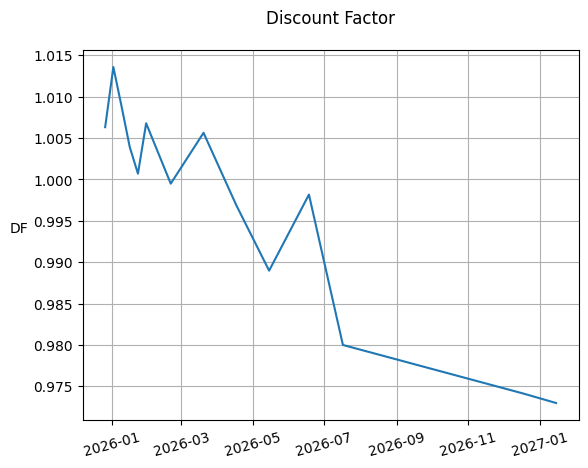

In [ ]:
import matplotlib.pyplot as plt

plt.title("Discount Factor", y=1.05)      # Title slightly above the plot.
plt.plot(processed_maturites, DFs)        # Plot DF(T) against each expiration date.
plt.grid(True)                            # Add grid for readability.
plt.ylabel("DF", rotation=0, labelpad=10) # Y-axis label.
plt.xticks(rotation=15)                   # Rotate dates so they don’t overlap.
plt.show()                                # Display the figure.


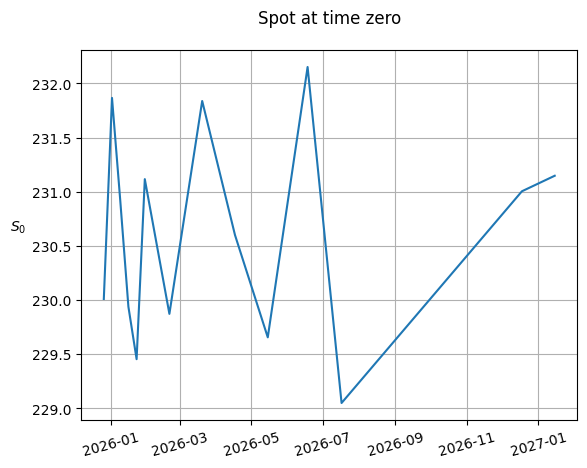

In [ ]:
import matplotlib.pyplot as plt

plt.title("Spot at time zero", y=1.05)       # Plot title.
plt.plot(processed_maturites, Ss)            # Plot the estimated S(T) (intercept) by expiration date.
plt.grid(True)                               # Add grid.
plt.ylabel(r"$S_0$", rotation=0, labelpad=10)# Y-axis label (math formatting).
plt.xticks(rotation=15)                      # Rotate dates for readability.
plt.show()                                   # Show the plot.


### As you (first hand) see, data can be a challenging business. We see some unexpected behaviour right? Why is this happening? let's check our samples

In [ ]:
DFs = []                 # Store DF(T) estimates.
Ss = []                  # Store S(T) estimates.
processed_maturites = [] # Store maturities that worked.

for maturity in maturities:                       # Loop over each expiration date.
    try:
        DF, S = put_call_regression(grouped_option_chain, maturity, 25, verbose=True)
        # Run the regression and print details (verbose=True).

        DFs.append(DF)                            # Save DF(T).
        Ss.append(S)                              # Save S(T).
        processed_maturites.append(maturity)      # Save the maturity processed successfully.
    except:
        pass                                      # Skip maturities where regression fails.


2025-12-26T00:00:00.000000000 : 17 samples | DF: 1.0063078317621466 | S_0: 230.01057469180554
2026-01-02T00:00:00.000000000 : 13 samples | DF: 1.0135760425183953 | S_0: 231.86686937857678
2026-01-09T00:00:00.000000000 : 6 samples | DF: 1.0088235294117687 | S_0: 230.92534313725588
2026-01-16T00:00:00.000000000 : 20 samples | DF: 1.0039067092651761 | S_0: 229.93874281150164
2026-01-23T00:00:00.000000000 : 8 samples | DF: 1.0006948853615534 | S_0: 229.45466490299862
2026-01-30T00:00:00.000000000 : 6 samples | DF: 1.006778378378377 | S_0: 231.11689189189144
2026-02-20T00:00:00.000000000 : 11 samples | DF: 0.999486486486487 | S_0: 229.87310810810828
2026-03-20T00:00:00.000000000 : 14 samples | DF: 1.0056260330578517 | S_0: 231.83854634002375
2026-04-17T00:00:00.000000000 : 6 samples | DF: 0.9968749999999984 | S_0: 230.60104166666622
2026-05-15T00:00:00.000000000 : 6 samples | DF: 0.9889786585365838 | S_0: 229.65617378048742
2026-06-18T00:00:00.000000000 : 7 samples | DF: 0.9981628959276028 

### Something seems to happen in "2026-01-16" right?

In [ ]:
expiration_date = "2026-01-16"          # Choose one specific expiration date to analyze.
volume_filter = 25                      # Minimum volume threshold (liquidity filter).

calls = grouped_option_chain.loc[(expiration_date, "C"), ["mid_price", "volume"]]
# Select call options ("C") for this expiration, keeping only mid_price and volume.

puts  = grouped_option_chain.loc[(expiration_date, "P"), ["mid_price", "volume"]]
# Select put options ("P") for this expiration, keeping only mid_price and volume.

calls = calls[calls["volume"] > volume_filter]
# Keep only calls with volume greater than 25.

puts  = puts[puts["volume"] > volume_filter]
# Keep only puts with volume greater than 25.

joined_df = calls.join(puts, how="inner", lsuffix="_call", rsuffix="_put")
# Join calls and puts by strike (the index). "inner" keeps only strikes that exist in both.

joined_df["call_minus_put"] = joined_df["mid_price_call"] - joined_df["mid_price_put"]
# Compute C(K,T) - P(K,T) for each strike.

joined_df.head()                         # Show the first rows to inspect the matched strikes.


,mid_price_call,volume_call,mid_price_put,volume_put,call_minus_put
strike,,,,,
160.0,69.275,32.0,0.070,578.0,69.205
170.0,59.325,47.0,0.115,1996.0,59.210
175.0,54.400,36.0,0.145,1239.0,54.255
180.0,49.425,40.0,0.165,1014.0,49.260
190.0,39.325,232.0,0.235,387.0,39.090


In [ ]:
option_chain["expiration_date"] = pd.to_datetime(option_chain["expiration_date"])
# Convert expiration_date to datetime so we can use .dt (date-time) operations.

sorted(option_chain["expiration_date"].dt.strftime("%Y-%m-%d").unique())[:20]
# Get the unique expiration dates, format them as YYYY-MM-DD strings, sort them, and show the first 20.


['2025-12-26',
 '2026-01-02',
 '2026-01-09',
 '2026-01-16',
 '2026-01-23',
 '2026-01-30',
 '2026-02-20',
 '2026-03-20',
 '2026-04-17',
 '2026-05-15',
 '2026-06-18',
 '2026-07-17',
 '2026-08-21',
 '2026-09-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17',
 '2027-12-17',
 '2028-01-21',
 '2028-06-16']

In [58]:
joined_df

,mid_price_call,volume_call,mid_price_put,volume_put,call_minus_put
strike,,,,,
160.0,69.275,32.0,0.070,578.0,69.205
170.0,59.325,47.0,0.115,1996.0,59.210
175.0,54.400,36.0,0.145,1239.0,54.255
180.0,49.425,40.0,0.165,1014.0,49.260
190.0,39.325,232.0,0.235,387.0,39.090
195.0,34.400,244.0,0.305,201.0,34.095
200.0,29.550,192.0,0.395,1681.0,29.155
205.0,24.675,32.0,0.575,2345.0,24.100
210.0,20.125,57.0,0.905,1981.0,19.220


### Here we go, so we found that mid_price has a zero value. How can we fix this? Well we can surely check that mid_price is greater than zero!

In [ ]:
def put_call_regression(grouped_df, expiration_date, volume_filter, verbose=False):
    """
    inputs:
    grouped_df: dataframe with multi-index [expiration_date, option_type, strike]
    expiration_date: one maturity date
    volume_filter: minimum volume required

    output:
    DF_T, S_T: Discount Factor and S coefficient from the Put-Call parity regression
    """

    calls = grouped_df.loc[(expiration_date, "C"), ["mid_price", "volume"]]
    # Select call options for this expiration (by strike), keeping mid_price and volume.

    puts  = grouped_df.loc[(expiration_date, "P"), ["mid_price", "volume"]]
    # Select put options for this expiration (by strike), keeping mid_price and volume.

    calls = calls.loc[(calls.volume > volume_filter) & (calls.mid_price > 0)]
    # Keep only calls with enough volume and a positive mid price.

    puts  = puts.loc[(puts.volume > volume_filter) & (puts.mid_price > 0)]
    # Keep only puts with enough volume and a positive mid price.

    joined_df = calls.join(puts, how="inner", lsuffix="_call", rsuffix="_put")
    # Match calls and puts by strike (inner join keeps only strikes that exist in both).

    joined_df["call_minus_put"] = joined_df.mid_price_call - joined_df.mid_price_put
    # Compute C(K,T) - P(K,T) for each matched strike.

    assert len(joined_df) > 1
    # We need at least 2 strikes to fit a straight line.

    result = np.polyfit(x=joined_df.index, y=joined_df.call_minus_put, deg=1)
    # Fit a line: (C - P) = a + b*K using strikes as x and (C-P) as y.

    DF_T = -result[0]
    # The slope b corresponds to -DF(T), so DF(T) = -b.

    S_T  = result[1]
    # The intercept a corresponds to S(T) in the parity equation.

    if verbose:
        print(expiration_date, ":", len(joined_df), "samples | DF:", DF_T, "| S_0:", S_T)
        # Print a quick summary for this maturity if verbose=True.

    return DF_T, S_T


In [ ]:
DFs = []                 # Store DF(T) estimates for each maturity.
Ss = []                  # Store S(T) (intercept) estimates for each maturity.
processed_maturites = [] # Store maturities where the regression worked.

for maturity in maturities:                     # Loop over all expiration dates.
    try:
        DF, S = put_call_regression(grouped_option_chain, maturity, 25, verbose=True)
        # Run the regression for this maturity (volume filter = 25) and print the output.

        DFs.append(DF)                          # Save the discount factor estimate.
        Ss.append(S)                            # Save the spot/intercept estimate.
        processed_maturites.append(maturity)    # Save the maturity we successfully processed.
    except:
        pass                                    # If it fails (e.g., not enough strikes), skip it.


2025-12-26T00:00:00.000000000 : 17 samples | DF: 1.0063078317621466 | S_0: 230.01057469180554
2026-01-02T00:00:00.000000000 : 13 samples | DF: 1.0135760425183953 | S_0: 231.86686937857678
2026-01-09T00:00:00.000000000 : 6 samples | DF: 1.0088235294117687 | S_0: 230.92534313725588
2026-01-16T00:00:00.000000000 : 20 samples | DF: 1.0039067092651761 | S_0: 229.93874281150164
2026-01-23T00:00:00.000000000 : 8 samples | DF: 1.0006948853615534 | S_0: 229.45466490299862
2026-01-30T00:00:00.000000000 : 6 samples | DF: 1.006778378378377 | S_0: 231.11689189189144
2026-02-20T00:00:00.000000000 : 11 samples | DF: 0.999486486486487 | S_0: 229.87310810810828
2026-03-20T00:00:00.000000000 : 14 samples | DF: 1.0056260330578517 | S_0: 231.83854634002375
2026-04-17T00:00:00.000000000 : 6 samples | DF: 0.9968749999999984 | S_0: 230.60104166666622
2026-05-15T00:00:00.000000000 : 6 samples | DF: 0.9889786585365838 | S_0: 229.65617378048742
2026-06-18T00:00:00.000000000 : 7 samples | DF: 0.9981628959276028 

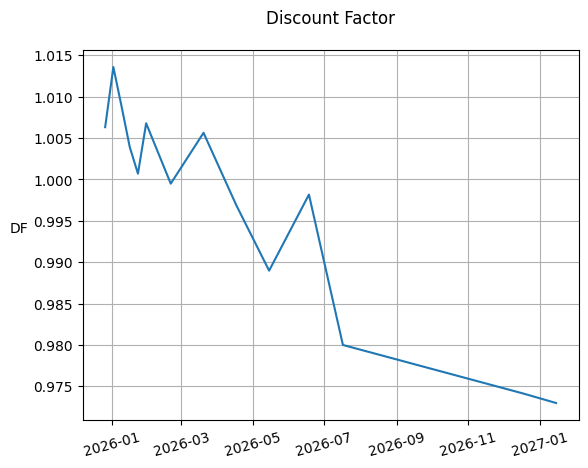

In [ ]:
plt.title("Discount Factor", y=1.05)          # Add a title (slightly above the plot).
plt.plot(processed_maturites, DFs)            # Plot DF(T) for each processed expiration date.
plt.grid(True)                                # Turn on grid lines to make it easier to read.
plt.ylabel("DF", rotation=0, labelpad=10)     # Label the y-axis as DF.
plt.xticks(rotation=15)                       # Rotate date labels so they don’t overlap.
plt.show()                                    # Display the figure.


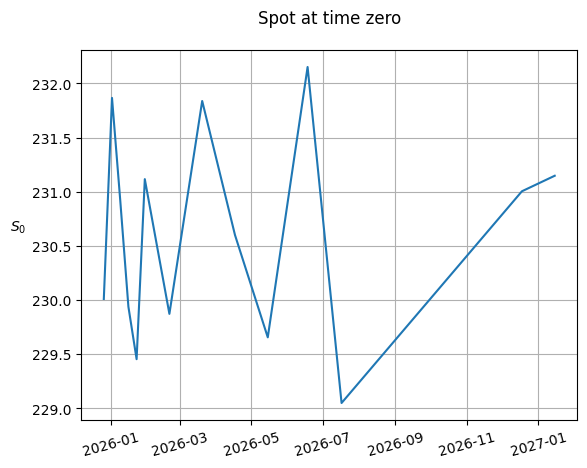

In [ ]:
plt.title("Spot at time zero", y=1.05)        # Title for the plot.
plt.plot(processed_maturites, Ss)             # Plot the estimated S(T) (intercept) by expiration date.
plt.grid(True)                                # Add grid lines.
plt.ylabel(r"$S_0$", rotation=0, labelpad=10) # Y-axis label in math format.
plt.xticks(rotation=15)                       # Rotate date labels for readability.
plt.show()                                    # Show the plot.


### Bottomline here: you will face this kind of "issue" when dealing with data. Be prepared to debug and adapt your code to detect these anomalies. You can of course leave the task without the cleaning part, but as a good future quant you should question these anomalies

# Exercise 2:

### a) Using the forward prices $F(T)$ and Discount Factors $DF(T)$ obtained previously, calculate the implied volatility of each option using the  ```mid_price```. (Note that you will need to use the implied volatility calculation that you did in the Session 2 assignment)

Recall that in the Black-Scholes model, the value of a European Call option on $(S_t)_{t\geq 0}$ is given at inception by,
    $$C^{\mathrm{BS}}(S_0, K, T;\sigma) = S(T)\left(\mathcal{N}(d_{+}) - DF(T)K\mathcal{N}(d_{-})\right)$$
    $$d_{\pm} = \frac{\log\left(\frac{F(T)}{K}\right)}{\sigma\sqrt{T}} \pm\frac{\sigma\sqrt{T}}{2}$$
    
 Where $F(T)=\frac{S(T)}{DF(T)}$
  

### Remark1 : Try to optimize your code to execute efficiently
### Remark2 : Note that some mid prices might lead to arbitrage and the solution for implied volatility might not exist


### a) let us first deal with the fact that we were not able to compute $DF$ and $S$ for all expirations. To fix this we will need to apply some kind of interpolation

In [ ]:
dataframe = pd.DataFrame(index=maturities)
# Create an empty DataFrame indexed by all maturities (expiration dates).

dataframe["DF"] = np.nan
# Add a DF column and initialize it with NaN (missing) values.

dataframe["S"] = np.nan
# Add an S column and initialize it with NaN values.

dataframe.loc[processed_maturites, "DF"] = DFs
# Fill DF only for maturities where the regression worked.

dataframe.loc[processed_maturites, "S"] = Ss
# Fill S only for maturities where the regression worked.


    ## For simplicity we will apply linear interpolation

                  DF           S
2025-12-26  1.006308  230.010575
2026-01-02  1.013576  231.866869
2026-01-09  1.008824  230.925343
2026-01-16  1.003907  229.938743
2026-01-23  1.000695  229.454665
2026-01-30  1.006778  231.116892
2026-02-20  0.999486  229.873108
2026-03-20  1.005626  231.838546
2026-04-17  0.996875  230.601042
2026-05-15  0.988979  229.656174
2026-06-18  0.998163  232.152165
2026-07-17  0.980000  229.050000
2026-08-21  0.978045  229.701629
2026-09-18  0.976090  230.353259
2026-12-18  0.974134  231.004888
2027-01-15  0.972989  231.148179
2027-06-17  0.972989  231.148179
2027-12-17  0.972989  231.148179
2028-01-21  0.972989  231.148179
2028-06-16  0.972989  231.148179


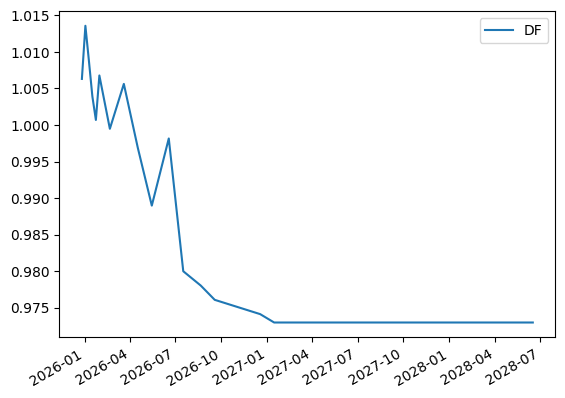

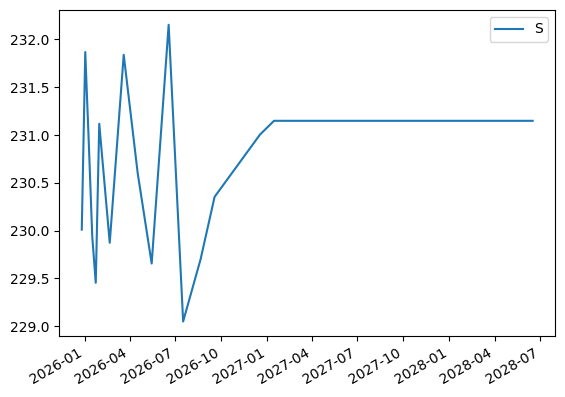

In [ ]:
interpolated_df = dataframe.interpolate(method="linear", axis=0, limit_direction="both")
# Fill missing DF and S values by linear interpolation along the maturity (index).
# limit_direction="both" also fills NaNs at the start/end using the closest available values.
interpolated_df.plot(y="DF")
# Plot the interpolated discount factor curve across maturities.
interpolated_df.plot(y="S")
# Plot the interpolated S curve across maturities.
print(interpolated_df)
# Print the full table with original + interpolated values.


# Let us now fill our original option_chain dataframe with $DF$ and $S$

In [ ]:
option_chain["DF"] = interpolated_df.loc[option_chain.expiration_date, "DF"].values
# For each option row, assign DF(T) by looking up its expiration_date in interpolated_df.
option_chain["S"]  = interpolated_df.loc[option_chain.expiration_date, "S"].values
# Same idea for S(T): match by expiration_date and copy the interpolated S value.
option_chain.head()
# Show the first rows to confirm DF and S were added correctly.


,contractSymbol,option_type,expiration_date,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,trade_date,mid_price,T,S_T,DF_T,DF,S
0,AMZN251226C00125000,C,2025-12-26,125.0,102.05,105.45,1.0,17,2.462894,True,2025-12-22,103.75,0.009132,229.299783,1.003112,1.006308,230.010575
1,AMZN251226C00130000,C,2025-12-26,130.0,96.95,100.45,1.0,8,2.261723,True,2025-12-22,98.70,0.009132,229.299783,1.003112,1.006308,230.010575
2,AMZN251226C00135000,C,2025-12-26,135.0,91.95,95.45,2.0,31,2.125005,True,2025-12-22,93.70,0.009132,229.299783,1.003112,1.006308,230.010575
3,AMZN251226C00140000,C,2025-12-26,140.0,86.95,90.45,2.0,3,1.994141,True,2025-12-22,88.70,0.009132,229.299783,1.003112,1.006308,230.010575
4,AMZN251226C00145000,C,2025-12-26,145.0,82.10,85.50,NaN,2,1.958985,True,2025-12-22,83.80,0.009132,229.299783,1.003112,1.006308,230.010575


### We will create a smaller dataframe with the columns we need to perform Black-Scholes to Implied Volatility trasform

In [ ]:
option_chain_reduced = option_chain.loc[:, ["S", "strike", "T", "option_type", "mid_price", "DF"]]
# Keep only the columns needed for the next steps (pricing / implied volatility).
option_chain_reduced.head()
# Preview the reduced dataset.


,S,strike,T,option_type,mid_price,DF
0,230.010575,125.0,0.009132,C,103.75,1.006308
1,230.010575,130.0,0.009132,C,98.70,1.006308
2,230.010575,135.0,0.009132,C,93.70,1.006308
3,230.010575,140.0,0.009132,C,88.70,1.006308
4,230.010575,145.0,0.009132,C,83.80,1.006308


In [ ]:
### Let us now use apply function

from scipy.optimize import fsolve, brentq   # Numerical solvers (we mainly use brentq for robustness).
from scipy.stats import norm                # Normal CDF for Black–Scholes formulas.
import numpy as np                          # Numerical computing (logs, sqrt, arrays, etc.).

def BS_european_option(S0, K, sigma, CP, T, DF):
    """
    Black–Scholes option price using a discount factor DF = exp(-rT).
    CP: 'C' for call, 'P' for put
    """
    if T <= 0 or sigma <= 0:
        # Edge case: if no time left (or sigma invalid), return intrinsic value.
        if CP == "C":
            return max(S0 - K, 0.0)         # Call intrinsic value.
        else:
            return max(K * DF - S0, 0.0)    # Put intrinsic value (using discounted strike).

    vol_sqrt = sigma * np.sqrt(T)           # sigma * sqrt(T), used repeatedly in d1/d2.

    # Using DF = exp(-rT) implies K*DF is the discounted strike.
    d1 = (np.log(S0 / (K * DF)) + 0.5 * sigma * sigma * T) / vol_sqrt
    d2 = d1 - vol_sqrt

    if CP == "C":
        return S0 * norm.cdf(d1) - K * DF * norm.cdf(d2)          # Call BS price.
    else:
        return K * DF * norm.cdf(-d2) - S0 * norm.cdf(-d1)        # Put BS price.

def implied_vol(price, S0, K, T, CP, DF):
    """
    Compute implied volatility by solving: BS_price(sigma) = market_price.
    Uses brentq (a bracketed root solver). Returns NaN if no valid solution.
    """
    if price <= 0 or S0 <= 0 or K <= 0 or T <= 0 or DF <= 0:
        return np.nan                        # Basic input sanity check.

    def obj(sigma):
        return BS_european_option(S0, K, sigma, CP, T, DF) - price
        # Objective is zero when BS price matches the observed market price.

    lo, hi = 1e-6, 5.0                       # Search interval for sigma (0% to 500% annualized).

    try:
        f_lo = obj(lo)
        f_hi = obj(hi)

        if np.sign(f_lo) == np.sign(f_hi):
            return np.nan                    # No sign change => no guaranteed root in [lo, hi].

        return brentq(obj, lo, hi, maxiter=200)
        # Find sigma that sets obj(sigma)=0.

    except Exception:
        return np.nan                        # If solver fails, return NaN.

def apply_func(x):
    # x is a row array: [S, strike, T, option_type, mid_price, DF]
    S0, K, T, CP, mid, DF = x                # Unpack the row values.
    return implied_vol(mid, S0, K, T, CP, DF)# Return implied volatility for that option.


In [ ]:
import time
start_time = time.time()
# Start a timer so we can measure how long the IV computation takes.

option_chain["IV"] = option_chain_reduced.apply(apply_func, axis=1, raw=True)
# Apply apply_func row-by-row (axis=1) to compute implied volatility for each option.
# raw=True passes each row as a NumPy array (faster than a pandas Series).

print("IV computation took", time.time() - start_time, "seconds")
# Print the elapsed time.

option_chain[["expiration_date", "strike", "option_type", "mid_price", "DF", "S", "T", "IV"]].head()
# Show a quick preview of the main columns plus the computed implied volatility.


IV computation took 3.752715826034546 seconds


,expiration_date,strike,option_type,mid_price,DF,S,T,IV
0,2025-12-26,125.0,C,103.75,1.006308,230.010575,0.009132,NaN
1,2025-12-26,130.0,C,98.70,1.006308,230.010575,0.009132,NaN
2,2025-12-26,135.0,C,93.70,1.006308,230.010575,0.009132,NaN
3,2025-12-26,140.0,C,88.70,1.006308,230.010575,0.009132,NaN
4,2025-12-26,145.0,C,83.80,1.006308,230.010575,0.009132,NaN
